# Iris Tension Ring Detection - Adaptive Multi-Dataset Pipeline

**Purpose**: Detect stress levels in iris images by counting tension rings using an adaptive approach that handles multiple dataset types.

---

## 🎯 Pipeline Overview

This notebook implements an **adaptive strategy** that handles 3 different dataset types:

### 📦 Dataset Types:

1. **MMU Dataset (Ground Truth)**
   - Has separate `.bmp` mask files with perfect segmentation
   - Strategy: Extract coordinates directly from masks (100% accurate)
   - QC: Auto-pass (masks guarantee quality)

2. **Stressed Dataset (Tension Rings)**
   - Images with visible stress indicators
   - Strategy: Auto-calibrated detection with standardization
   - QC: Auto-pass (too valuable to lose any samples)

3. **Normal/Color Dataset (CASIA, etc.)**
   - Standard iris images without stress
   - Strategy: Standard QC + auto-calibrated detection
   - QC: Apply blur/brightness/contrast checks

---

## 🔄 Processing Flow:

```
Input Images
     |
     v
[Detect Dataset Type]
     |
     +---> MMU? ---------> Extract from Mask -----+
     |                                             |
     +---> Stressed? ----> Auto-pass + Detect ----+
     |                                             |
     +---> Normal? -------> QC + Detect ----------+
                                                   |
                                                   v
                                        [Unwrap Iris]
                                                   |
                                                   v
                                        [Count Tension Rings]
                                                   |
                                                   v
                                        [Classify: Normal/Stressed]
```

---

## 📊 Key Features:

- ✅ **Adaptive QC**: Different rules for different datasets
- ✅ **Auto-Calibration**: Finds optimal detection parameters automatically
- ✅ **Image Standardization**: CLAHE + resizing for consistent detection
- ✅ **3-Tier Fallback**: JACKPOT → Tiny Pupil → Occluded Iris
- ✅ **Full Traceability**: Tracks dataset type, method, configs used
- ✅ **Zero Data Loss**: Preserves all valuable stressed images

---

**Created**: November 2025  
**Last Updated**: November 9, 2025

---

# Section 1: Imports & Environment Setup

Import all required libraries for image processing, detection, analysis, and visualization.

In [13]:
# Core Libraries
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("✅ IMPORTS SUCCESSFUL")
print("="*80)
print(f"\n📦 Library Versions:")
print(f"   - OpenCV: {cv2.__version__}")
print(f"   - NumPy: {np.__version__}")
print(f"   - Pandas: {pd.__version__}")
print(f"\n🎨 Matplotlib backend: {plt.get_backend()}")
print(f"\n⏰ Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n🚀 Ready to begin adaptive iris tension ring detection!")

✅ IMPORTS SUCCESSFUL

📦 Library Versions:
   - OpenCV: 4.12.0
   - NumPy: 2.0.2
   - Pandas: 2.3.3

🎨 Matplotlib backend: module://matplotlib_inline.backend_inline

⏰ Session started: 2025-11-09 10:43:42

🚀 Ready to begin adaptive iris tension ring detection!


---

# Section 2: Configuration & Path Setup

Define all paths, parameters, and utility functions for the adaptive pipeline.

## 2.1 Directory Structure Setup

Define the complete directory structure for input datasets and output organization.

In [14]:
# ============================================================================
# BASE PATHS
# ============================================================================
BASE_DIR = Path(r"G:\Iris_Stress_Detector\DataSet")

# ============================================================================
# INPUT DATASET PATHS (3 Types)
# ============================================================================

# 1. STRESSED DATASET (Eyes with Tension Rings)
STRESSED_INPUT_DIR = BASE_DIR / "Iris stream dataset" / "Eyes with Tension Rings - Stress Dataset"

# 2. NORMAL/COLOR DATASET (Iris stream dataset - CASIA, etc.)
NORMAL_INPUT_DIR = BASE_DIR / "Iris stream dataset" / "Iris Dataset" / "Dataset"

# 3. MMU DATASET (With ground truth masks)
MMU_INPUT_DIR = BASE_DIR / "Iris stream dataset" / "MMUDataSet $ Ground Thruth" / "MMU-Iris-Database"
MMU_MASKS_DIR = BASE_DIR / "Iris stream dataset" / "MMUDataSet $ Ground Thruth" / "Masks-for-MMU-Iris-dataset-main"

# ============================================================================
# OUTPUT DIRECTORY STRUCTURE
# ============================================================================
OUTPUT_DIR = BASE_DIR / "Iris stream dataset" / "QC_Results"

# QC Output Folders
QC_PASSED_DIR = OUTPUT_DIR / "QC_Passed"
QC_FAILED_DIR = OUTPUT_DIR / "QC_Failed"

# QC Passed Sub-folders (by dataset type)
QC_PASSED_STRESSED_DIR = QC_PASSED_DIR / "stressed"
QC_PASSED_NORMAL_DIR = QC_PASSED_DIR / "normal"
QC_PASSED_MMU_DIR = QC_PASSED_DIR / "mmu"

# QC Failed Sub-folders (by dataset type)
QC_FAILED_STRESSED_DIR = QC_FAILED_DIR / "stressed"
QC_FAILED_NORMAL_DIR = QC_FAILED_DIR / "normal"
QC_FAILED_MMU_DIR = QC_FAILED_DIR / "mmu"

# Logging & Visualization Folders
QC_REPORTS_DIR = OUTPUT_DIR / "QC_Reports"
QC_VISUALIZATIONS_DIR = OUTPUT_DIR / "QC_Visualizations"

# ============================================================================
# CREATE ALL DIRECTORIES
# ============================================================================
directories = [
    QC_PASSED_STRESSED_DIR,
    QC_PASSED_NORMAL_DIR,
    QC_PASSED_MMU_DIR,
    QC_FAILED_STRESSED_DIR,
    QC_FAILED_NORMAL_DIR,
    QC_FAILED_MMU_DIR,
    QC_REPORTS_DIR,
    QC_VISUALIZATIONS_DIR
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)

print("="*80)
print("✅ DIRECTORY STRUCTURE CREATED")
print("="*80)

print("\n📁 INPUT DATASETS:")
print(f"   - Stressed: {STRESSED_INPUT_DIR}")
print(f"     (Exists: {STRESSED_INPUT_DIR.exists()})")
print(f"   - Normal: {NORMAL_INPUT_DIR}")
print(f"     (Exists: {NORMAL_INPUT_DIR.exists()})")
print(f"   - MMU Images: {MMU_INPUT_DIR}")
print(f"     (Exists: {MMU_INPUT_DIR.exists()})")
print(f"   - MMU Masks: {MMU_MASKS_DIR}")
print(f"     (Exists: {MMU_MASKS_DIR.exists()})")

print("\n📂 OUTPUT STRUCTURE:")
print(f"   {OUTPUT_DIR}/")
print(f"   ├── QC_Passed/")
print(f"   │   ├── stressed/")
print(f"   │   ├── normal/")
print(f"   │   └── mmu/")
print(f"   ├── QC_Failed/")
print(f"   │   ├── stressed/")
print(f"   │   ├── normal/")
print(f"   │   └── mmu/")
print(f"   ├── QC_Reports/")
print(f"   └── QC_Visualizations/")

print("\n✅ All directories ready!")

✅ DIRECTORY STRUCTURE CREATED

📁 INPUT DATASETS:
   - Stressed: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Eyes with Tension Rings - Stress Dataset
     (Exists: True)
   - Normal: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Iris Dataset\Dataset
     (Exists: True)
   - MMU Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\MMUDataSet $ Ground Thruth\MMU-Iris-Database
     (Exists: True)
   - MMU Masks: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\MMUDataSet $ Ground Thruth\Masks-for-MMU-Iris-dataset-main
     (Exists: True)

📂 OUTPUT STRUCTURE:
   G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results/
   ├── QC_Passed/
   │   ├── stressed/
   │   ├── normal/
   │   └── mmu/
   ├── QC_Failed/
   │   ├── stressed/
   │   ├── normal/
   │   └── mmu/
   ├── QC_Reports/
   └── QC_Visualizations/

✅ All directories ready!


## 2.2 QC Parameters & Thresholds

Define quality control thresholds for blur, brightness, and contrast checks.

In [15]:
# ============================================================================
# QUALITY CONTROL THRESHOLDS
# ============================================================================

QC_PARAMS = {
    # Blur Detection (Laplacian Variance)
    'blur_threshold': 5,  # Images with variance < 5 are considered too blurry
    
    # Brightness Range (Mean Pixel Value)
    'brightness_min': 20,   # Too dark if mean < 20
    'brightness_max': 235,  # Too bright if mean > 235
    
    # Contrast Detection (Standard Deviation)
    'contrast_threshold': 15,  # Images with std dev < 15 are low contrast
    
    # Image Size Requirements
    'min_width': 100,
    'min_height': 100,
}

# ============================================================================
# DATASET-SPECIFIC QC RULES
# ============================================================================

QC_RULES = {
    'STRESSED': {
        'apply_qc': False,  # ⚠️ NEVER reject stressed images - too valuable!
        'reason': 'Auto-pass: Stressed dataset is too valuable to lose samples'
    },
    
    'MMU': {
        'apply_qc': True,   # ✅ Apply full QC to MMU dataset
        'reason': 'Full QC: MMU has ground truth masks, quality matters'
    },
    
    'NORMAL': {
        'apply_qc': True,   # ✅ Apply full QC to normal/color dataset
        'reason': 'Full QC: Standard iris images need quality filtering'
    }
}

print("="*80)
print("✅ QC PARAMETERS CONFIGURED")
print("="*80)

print("\n📊 QC Thresholds:")
print(f"   - Blur (Laplacian variance): < {QC_PARAMS['blur_threshold']} = BLURRY")
print(f"   - Brightness (mean pixel): {QC_PARAMS['brightness_min']}-{QC_PARAMS['brightness_max']}")
print(f"   - Contrast (std dev): < {QC_PARAMS['contrast_threshold']} = LOW CONTRAST")
print(f"   - Min dimensions: {QC_PARAMS['min_width']}x{QC_PARAMS['min_height']}")

print("\n🎯 Dataset-Specific QC Rules:")
for dataset, rules in QC_RULES.items():
    status = "❌ SKIP QC" if not rules['apply_qc'] else "✅ APPLY QC"
    print(f"   {dataset:10s}: {status}")
    print(f"              → {rules['reason']}")

print("\n✅ Configuration ready!")

✅ QC PARAMETERS CONFIGURED

📊 QC Thresholds:
   - Blur (Laplacian variance): < 5 = BLURRY
   - Brightness (mean pixel): 20-235
   - Contrast (std dev): < 15 = LOW CONTRAST
   - Min dimensions: 100x100

🎯 Dataset-Specific QC Rules:
   STRESSED  : ❌ SKIP QC
              → Auto-pass: Stressed dataset is too valuable to lose samples
   MMU       : ✅ APPLY QC
              → Full QC: MMU has ground truth masks, quality matters
   NORMAL    : ✅ APPLY QC
              → Full QC: Standard iris images need quality filtering

✅ Configuration ready!


## 2.3 QC Helper Functions

Define the quality control check functions for blur, brightness, and contrast detection.

In [16]:
def check_blur(image):
    """
    Detect if image is too blurry using Laplacian variance.
    
    Higher variance = sharper edges = better quality
    Lower variance = blurry = poor quality
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input image (BGR or grayscale)
    
    Returns:
    --------
    tuple : (is_sharp, variance_value)
        - is_sharp: True if image passes blur check
        - variance_value: Laplacian variance score
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    
    is_sharp = variance >= QC_PARAMS['blur_threshold']
    return is_sharp, variance


def check_brightness(image):
    """
    Check if image brightness is within acceptable range.
    
    Too dark or too bright images lose detail.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input image (BGR or grayscale)
    
    Returns:
    --------
    tuple : (is_good_brightness, mean_value)
        - is_good_brightness: True if brightness is acceptable
        - mean_value: Mean pixel intensity (0-255)
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    mean_value = gray.mean()
    
    is_good = QC_PARAMS['brightness_min'] <= mean_value <= QC_PARAMS['brightness_max']
    return is_good, mean_value


def check_contrast(image):
    """
    Check if image has sufficient contrast.
    
    Low contrast images lack detail differentiation.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input image (BGR or grayscale)
    
    Returns:
    --------
    tuple : (is_good_contrast, std_value)
        - is_good_contrast: True if contrast is acceptable
        - std_value: Standard deviation of pixel intensities
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    std_value = gray.std()
    
    is_good = std_value >= QC_PARAMS['contrast_threshold']
    return is_good, std_value


def check_image_size(image):
    """
    Check if image meets minimum size requirements.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input image
    
    Returns:
    --------
    tuple : (is_valid_size, height, width)
    """
    h, w = image.shape[:2]
    is_valid = (w >= QC_PARAMS['min_width'] and h >= QC_PARAMS['min_height'])
    return is_valid, h, w


def run_qc_checks(image_path, dataset_type):
    """
    Run complete QC pipeline on an image based on dataset type.
    
    Parameters:
    -----------
    image_path : str or Path
        Path to image file
    dataset_type : str
        One of: 'STRESSED', 'MMU', 'NORMAL'
    
    Returns:
    --------
    dict : QC results containing:
        - status: 'passed', 'failed', 'auto_pass'
        - reasons: list of failure reasons (if any)
        - metrics: dict of all measured values
    """
    results = {
        'filename': Path(image_path).name,
        'dataset_type': dataset_type,
        'status': None,
        'reasons': [],
        'metrics': {}
    }
    
    # Check if QC should be applied to this dataset type
    if not QC_RULES[dataset_type]['apply_qc']:
        results['status'] = 'auto_pass'
        results['reasons'].append(QC_RULES[dataset_type]['reason'])
        return results
    
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        results['status'] = 'failed'
        results['reasons'].append('Failed to load image')
        return results
    
    # Run all checks
    is_sharp, blur_score = check_blur(image)
    is_bright, brightness = check_brightness(image)
    is_contrast, contrast = check_contrast(image)
    is_size, h, w = check_image_size(image)
    
    # Store metrics
    results['metrics'] = {
        'blur_score': blur_score,
        'brightness': brightness,
        'contrast': contrast,
        'height': h,
        'width': w
    }
    
    # Determine pass/fail
    all_checks = []
    
    if not is_sharp:
        results['reasons'].append(f'Too blurry (variance={blur_score:.2f} < {QC_PARAMS["blur_threshold"]})')
        all_checks.append(False)
    else:
        all_checks.append(True)
    
    if not is_bright:
        if brightness < QC_PARAMS['brightness_min']:
            results['reasons'].append(f'Too dark (mean={brightness:.1f} < {QC_PARAMS["brightness_min"]})')
        else:
            results['reasons'].append(f'Too bright (mean={brightness:.1f} > {QC_PARAMS["brightness_max"]})')
        all_checks.append(False)
    else:
        all_checks.append(True)
    
    if not is_contrast:
        results['reasons'].append(f'Low contrast (std={contrast:.2f} < {QC_PARAMS["contrast_threshold"]})')
        all_checks.append(False)
    else:
        all_checks.append(True)
    
    if not is_size:
        results['reasons'].append(f'Image too small ({w}x{h} < {QC_PARAMS["min_width"]}x{QC_PARAMS["min_height"]})')
        all_checks.append(False)
    else:
        all_checks.append(True)
    
    # Final status
    results['status'] = 'passed' if all(all_checks) else 'failed'
    
    if results['status'] == 'passed':
        results['reasons'] = ['All QC checks passed']
    
    return results


print("✅ QC Helper Functions Defined!")
print("\n📋 Available Functions:")
print("   - check_blur(image)")
print("   - check_brightness(image)")
print("   - check_contrast(image)")
print("   - check_image_size(image)")
print("   - run_qc_checks(image_path, dataset_type)")
print("\n🎯 Ready to run quality control!")

✅ QC Helper Functions Defined!

📋 Available Functions:
   - check_blur(image)
   - check_brightness(image)
   - check_contrast(image)
   - check_image_size(image)
   - run_qc_checks(image_path, dataset_type)

🎯 Ready to run quality control!


---

# Section 3: Quality Control Processing

Run QC on all three datasets separately to avoid collisions. Each dataset gets:
- Individual QC processing
- Separate visualizations
- Dedicated CSV reports
- Dataset-specific folder organization

## 3.1 QC for STRESSED Dataset (Auto-Pass)

Process the stressed dataset with auto-pass policy - all images are too valuable to reject.

In [17]:
print("="*80)
print("QC PROCESSING: STRESSED DATASET")
print("="*80)
print(f"\n📁 Input: {STRESSED_INPUT_DIR}")
print(f"⚠️  QC Policy: AUTO-PASS (Too valuable to lose)")

# Get all image files
stressed_files = list(STRESSED_INPUT_DIR.glob("*.jpg")) + \
                 list(STRESSED_INPUT_DIR.glob("*.png")) + \
                 list(STRESSED_INPUT_DIR.glob("*.jpeg")) + \
                 list(STRESSED_INPUT_DIR.glob("*.bmp"))

print(f"\n📊 Found {len(stressed_files)} images")

# Process all stressed images
stressed_results = []

for img_path in tqdm(stressed_files, desc="Processing Stressed Images"):
    qc_result = run_qc_checks(img_path, 'STRESSED')
    stressed_results.append(qc_result)
    
    # Copy to QC_PASSED (all stressed images auto-pass)
    dest_path = QC_PASSED_STRESSED_DIR / img_path.name
    shutil.copy2(img_path, dest_path)

# Create DataFrame
stressed_df = pd.DataFrame(stressed_results)

# Save CSV report
stressed_csv_path = QC_REPORTS_DIR / "qc_results_stressed.csv"
stressed_df.to_csv(stressed_csv_path, index=False)

print("\n" + "="*80)
print("STRESSED DATASET QC RESULTS")
print("="*80)
print(f"✅ Total Images: {len(stressed_df)}")
print(f"✅ All Passed (Auto-Pass): {len(stressed_df)}")
print(f"❌ Failed: 0")
print(f"\n📄 CSV Report: {stressed_csv_path}")
print(f"📁 Images Saved: {QC_PASSED_STRESSED_DIR}")
print(f"\n⚠️  Note: Stressed dataset auto-passes QC due to high value!")

QC PROCESSING: STRESSED DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Eyes with Tension Rings - Stress Dataset
⚠️  QC Policy: AUTO-PASS (Too valuable to lose)

📊 Found 102 images


QC PROCESSING: STRESSED DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Eyes with Tension Rings - Stress Dataset
⚠️  QC Policy: AUTO-PASS (Too valuable to lose)

📊 Found 102 images


Processing Stressed Images: 100%|██████████| 102/102 [00:00<00:00, 341.58it/s]

QC PROCESSING: STRESSED DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Eyes with Tension Rings - Stress Dataset
⚠️  QC Policy: AUTO-PASS (Too valuable to lose)

📊 Found 102 images


Processing Stressed Images: 100%|██████████| 102/102 [00:00<00:00, 341.58it/s]


STRESSED DATASET QC RESULTS
✅ Total Images: 102
✅ All Passed (Auto-Pass): 102
❌ Failed: 0

📄 CSV Report: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_results_stressed.csv
📁 Images Saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Passed\stressed

⚠️  Note: Stressed dataset auto-passes QC due to high value!


### 3.1.1 Visualization: Stressed Dataset QC Summary

Visualize the stressed dataset QC results (even though all auto-pass).

✅ Visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_stressed.png


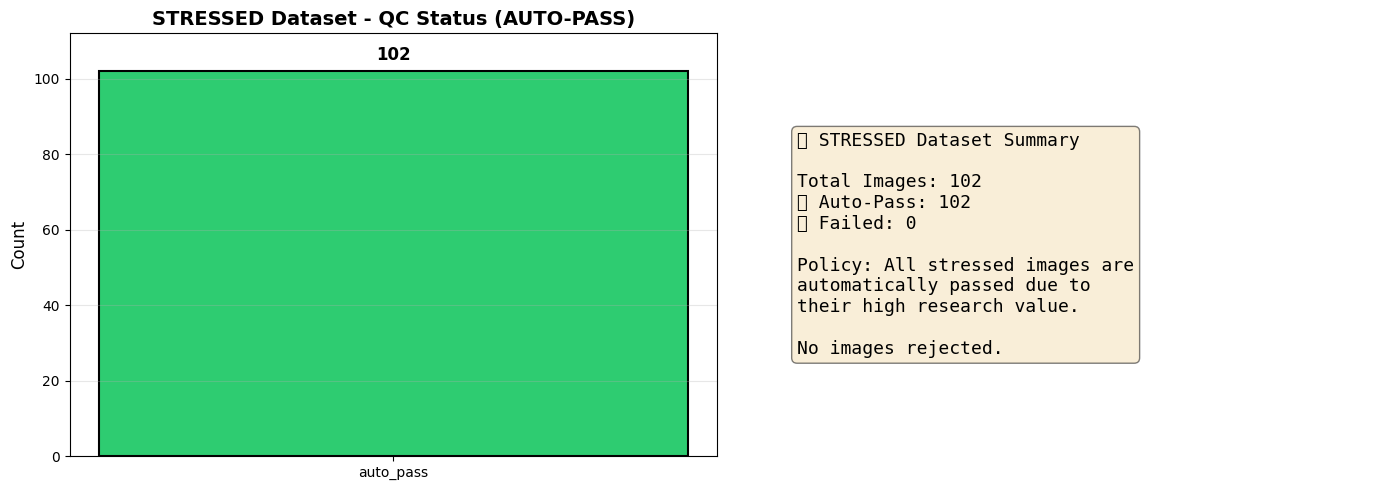

In [18]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Status Distribution (All Auto-Pass)
ax1 = axes[0]
status_counts = stressed_df['status'].value_counts()
colors = ['#2ecc71']  # Green for auto_pass
ax1.bar(status_counts.index, status_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('STRESSED Dataset - QC Status (AUTO-PASS)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, len(stressed_df) + 10)
for i, v in enumerate(status_counts.values):
    ax1.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Sample Images (Random 6)
ax2 = axes[1]
ax2.axis('off')
sample_text = f"📊 STRESSED Dataset Summary\n\n"
sample_text += f"Total Images: {len(stressed_df)}\n"
sample_text += f"✅ Auto-Pass: {len(stressed_df)}\n"
sample_text += f"❌ Failed: 0\n\n"
sample_text += f"Policy: All stressed images are\n"
sample_text += f"automatically passed due to\n"
sample_text += f"their high research value.\n\n"
sample_text += f"No images rejected."

ax2.text(0.1, 0.5, sample_text, fontsize=13, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
stressed_viz_path = QC_VISUALIZATIONS_DIR / "qc_summary_stressed.png"
plt.savefig(stressed_viz_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved: {stressed_viz_path}")

plt.show()

## 3.2 QC for MMU Dataset (Full QC with Mask Support)

Process the MMU dataset with full quality control. Passed images retain original filenames for easy mask matching.

In [19]:
print("="*80)
print("QC PROCESSING: MMU DATASET")
print("="*80)
print(f"\n📁 Input: {MMU_INPUT_DIR}")
print(f"✅ QC Policy: FULL QC (Quality matters with ground truth masks)")

# Get all image files (MMU uses .bmp format)
mmu_files = list(MMU_INPUT_DIR.glob("**/*.bmp"))  # Recursive search

print(f"\n📊 Found {len(mmu_files)} images")

# Process all MMU images
mmu_results = []

for img_path in tqdm(mmu_files, desc="Processing MMU Images"):
    qc_result = run_qc_checks(img_path, 'MMU')
    mmu_results.append(qc_result)
    
    # Copy to appropriate folder based on QC result
    # IMPORTANT: Keep original filename for mask matching!
    if qc_result['status'] == 'passed':
        dest_path = QC_PASSED_MMU_DIR / img_path.name
        shutil.copy2(img_path, dest_path)
    else:
        dest_path = QC_FAILED_MMU_DIR / img_path.name
        shutil.copy2(img_path, dest_path)

# Create DataFrame
mmu_df = pd.DataFrame(mmu_results)

# Save CSV report
mmu_csv_path = QC_REPORTS_DIR / "qc_results_mmu.csv"
mmu_df.to_csv(mmu_csv_path, index=False)

print("\n" + "="*80)
print("MMU DATASET QC RESULTS")
print("="*80)
print(f"📊 Total Images: {len(mmu_df)}")
print(f"✅ Passed: {(mmu_df['status'] == 'passed').sum()}")
print(f"❌ Failed: {(mmu_df['status'] == 'failed').sum()}")

if len(mmu_df) > 0:
    pass_rate = (mmu_df['status'] == 'passed').sum() / len(mmu_df) * 100
    print(f"📈 Pass Rate: {pass_rate:.1f}%")

print(f"\n📄 CSV Report: {mmu_csv_path}")
print(f"📁 Passed Images: {QC_PASSED_MMU_DIR}")
print(f"📁 Failed Images: {QC_FAILED_MMU_DIR}")
print(f"\n✅ Original filenames preserved for mask matching!")

QC PROCESSING: MMU DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\MMUDataSet $ Ground Thruth\MMU-Iris-Database
✅ QC Policy: FULL QC (Quality matters with ground truth masks)

📊 Found 450 images


Processing MMU Images: 100%|██████████| 450/450 [00:14<00:00, 30.55it/s]

QC PROCESSING: MMU DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\MMUDataSet $ Ground Thruth\MMU-Iris-Database
✅ QC Policy: FULL QC (Quality matters with ground truth masks)

📊 Found 450 images


Processing MMU Images: 100%|██████████| 450/450 [00:14<00:00, 30.55it/s]


MMU DATASET QC RESULTS
📊 Total Images: 450
✅ Passed: 450
❌ Failed: 0
📈 Pass Rate: 100.0%

📄 CSV Report: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_results_mmu.csv
📁 Passed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Passed\mmu
📁 Failed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Failed\mmu

✅ Original filenames preserved for mask matching!


QC PROCESSING: MMU DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\MMUDataSet $ Ground Thruth\MMU-Iris-Database
✅ QC Policy: FULL QC (Quality matters with ground truth masks)

📊 Found 450 images


Processing MMU Images: 100%|██████████| 450/450 [00:14<00:00, 30.55it/s]


MMU DATASET QC RESULTS
📊 Total Images: 450
✅ Passed: 450
❌ Failed: 0
📈 Pass Rate: 100.0%

📄 CSV Report: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_results_mmu.csv
📁 Passed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Passed\mmu
📁 Failed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Failed\mmu

✅ Original filenames preserved for mask matching!


### 3.2.1 Visualization: MMU Dataset QC Results

Visualize MMU dataset QC metrics and pass/fail distribution.

✅ Visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_mmu.png


✅ Visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_mmu.png


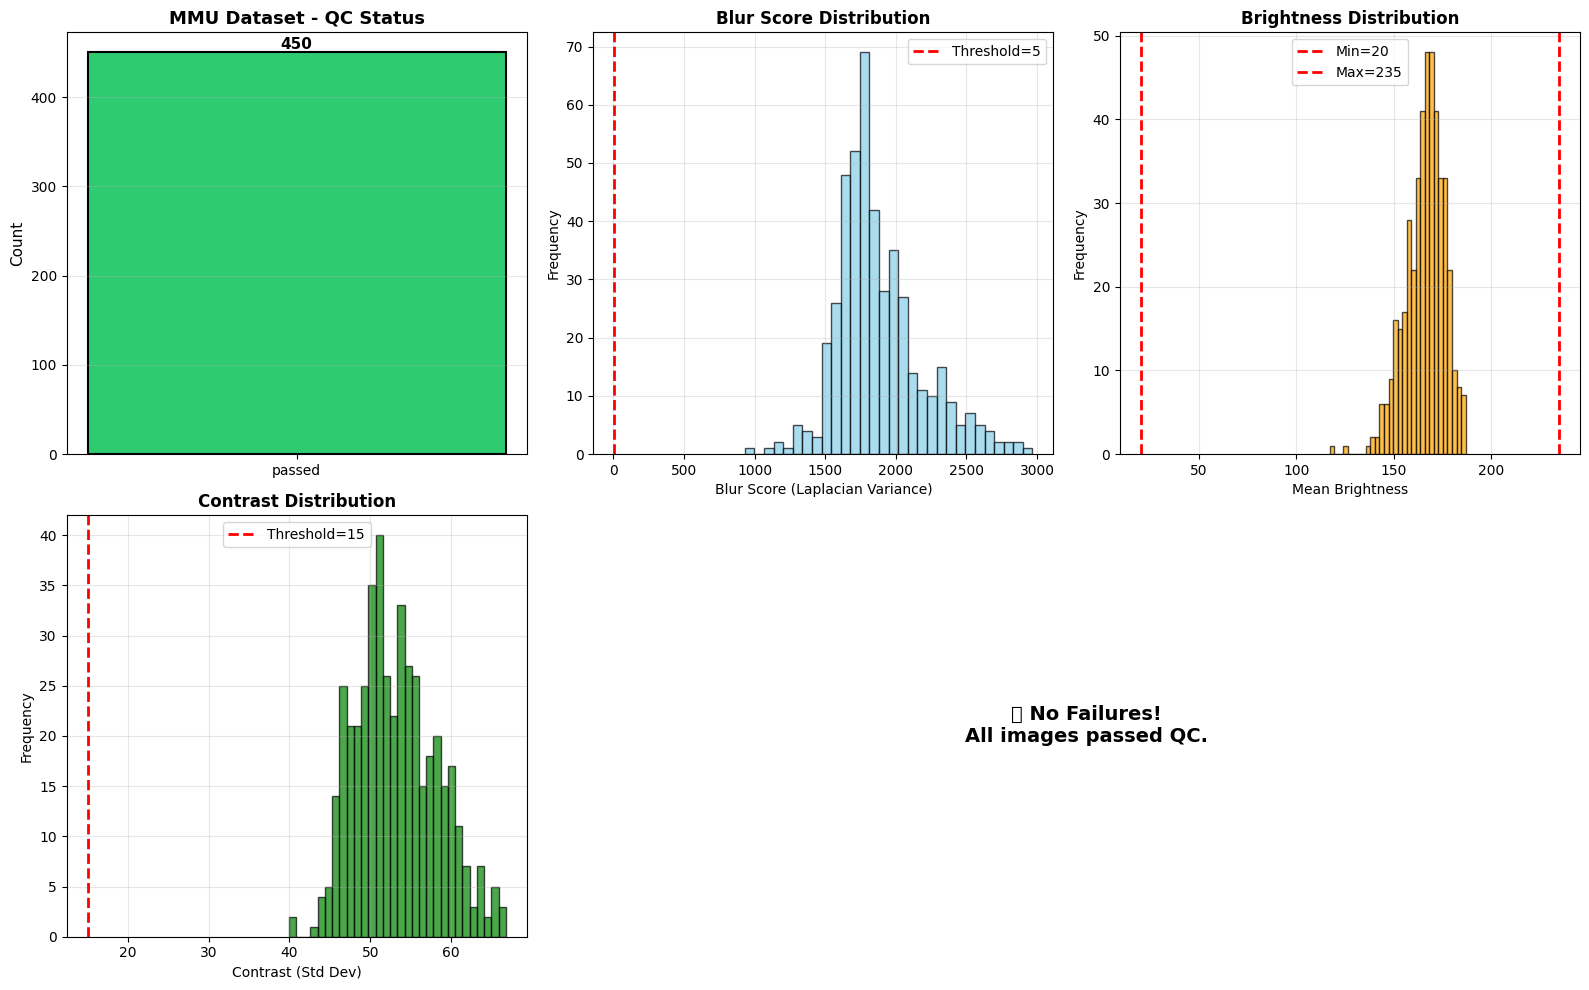

In [20]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

# Plot 1: Status Distribution
ax1 = fig.add_subplot(gs[0, 0])
status_counts = mmu_df['status'].value_counts()
colors = ['#2ecc71' if s == 'passed' else '#e74c3c' for s in status_counts.index]
bars = ax1.bar(status_counts.index, status_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('MMU Dataset - QC Status', fontsize=13, fontweight='bold')
for i, v in enumerate(status_counts.values):
    ax1.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Blur Scores (only for images with metrics)
ax2 = fig.add_subplot(gs[0, 1])
if 'metrics' in mmu_df.columns and len(mmu_df) > 0:
    blur_scores = [m.get('blur_score', 0) if isinstance(m, dict) else 0 for m in mmu_df['metrics']]
    ax2.hist(blur_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(QC_PARAMS['blur_threshold'], color='red', linestyle='--', linewidth=2, 
                label=f"Threshold={QC_PARAMS['blur_threshold']}")
    ax2.set_xlabel('Blur Score (Laplacian Variance)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Blur Score Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

# Plot 3: Brightness Distribution
ax3 = fig.add_subplot(gs[0, 2])
if 'metrics' in mmu_df.columns and len(mmu_df) > 0:
    brightness = [m.get('brightness', 0) if isinstance(m, dict) else 0 for m in mmu_df['metrics']]
    ax3.hist(brightness, bins=30, color='orange', edgecolor='black', alpha=0.7)
    ax3.axvline(QC_PARAMS['brightness_min'], color='red', linestyle='--', linewidth=2, 
                label=f"Min={QC_PARAMS['brightness_min']}")
    ax3.axvline(QC_PARAMS['brightness_max'], color='red', linestyle='--', linewidth=2,
                label=f"Max={QC_PARAMS['brightness_max']}")
    ax3.set_xlabel('Mean Brightness', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('Brightness Distribution', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

# Plot 4: Contrast Distribution
ax4 = fig.add_subplot(gs[1, 0])
if 'metrics' in mmu_df.columns and len(mmu_df) > 0:
    contrast = [m.get('contrast', 0) if isinstance(m, dict) else 0 for m in mmu_df['metrics']]
    ax4.hist(contrast, bins=30, color='green', edgecolor='black', alpha=0.7)
    ax4.axvline(QC_PARAMS['contrast_threshold'], color='red', linestyle='--', linewidth=2,
                label=f"Threshold={QC_PARAMS['contrast_threshold']}")
    ax4.set_xlabel('Contrast (Std Dev)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.set_title('Contrast Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

# Plot 5: Failure Reasons
ax5 = fig.add_subplot(gs[1, 1:])
failed_df = mmu_df[mmu_df['status'] == 'failed']
if len(failed_df) > 0:
    # Count failure reasons
    all_reasons = []
    for reasons in failed_df['reasons']:
        if isinstance(reasons, list):
            all_reasons.extend(reasons)
    
    if all_reasons:
        reason_counts = pd.Series(all_reasons).value_counts()
        ax5.barh(range(len(reason_counts)), reason_counts.values, color='#e74c3c', edgecolor='black', alpha=0.7)
        ax5.set_yticks(range(len(reason_counts)))
        ax5.set_yticklabels([r[:50] + '...' if len(r) > 50 else r for r in reason_counts.index], fontsize=9)
        ax5.set_xlabel('Count', fontsize=10)
        ax5.set_title('Failure Reasons Distribution', fontsize=12, fontweight='bold')
        ax5.grid(axis='x', alpha=0.3)
        for i, v in enumerate(reason_counts.values):
            ax5.text(v + 0.5, i, str(v), va='center', fontsize=9)
else:
    ax5.text(0.5, 0.5, '✅ No Failures!\nAll images passed QC.', 
             ha='center', va='center', fontsize=14, fontweight='bold',
             transform=ax5.transAxes)
    ax5.axis('off')

plt.tight_layout()

# Save figure
mmu_viz_path = QC_VISUALIZATIONS_DIR / "qc_summary_mmu.png"
plt.savefig(mmu_viz_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved: {mmu_viz_path}")

plt.show()

## 3.3 QC for NORMAL Dataset (Full QC - Iris Stream Dataset)

Process the normal/color iris dataset (CASIA, etc.) with full quality control filtering.

In [23]:
print("="*80)
print("QC PROCESSING: NORMAL DATASET")
print("="*80)
print(f"\n📁 Input: {NORMAL_INPUT_DIR}")
print(f"✅ QC Policy: FULL QC (Standard quality filtering)")
print(f"⚙️  Pre-processing: Resize large images (max 1000px) before QC")

# Get all image files
normal_files = list(NORMAL_INPUT_DIR.glob("**/*.jpg")) + \
               list(NORMAL_INPUT_DIR.glob("**/*.png")) + \
               list(NORMAL_INPUT_DIR.glob("**/*.bmp"))

print(f"\n📊 Found {len(normal_files)} images")

# Create temporary directory for resized images
TEMP_RESIZED_DIR = OUTPUT_DIR / "temp_resized_normal"
TEMP_RESIZED_DIR.mkdir(parents=True, exist_ok=True)

# Process all normal images
normal_results = []
resized_count = 0

print(f"\n🔄 Resizing and processing images...")

for img_path in tqdm(normal_files, desc="Processing Normal Images"):
    # Load image
    img = cv2.imread(str(img_path))
    
    if img is None:
        # If image can't be loaded, still try QC (will fail gracefully)
        qc_result = run_qc_checks(img_path, 'NORMAL')
        normal_results.append(qc_result)
        continue
    
    # Create unique filename by prepending parent folder (subject ID)
    # E.g., IrisImage/1/L1.JPG → Subject001_L1.JPG
    parent_folder = img_path.parent.name  # Gets "1", "2", "100", etc.
    original_filename = img_path.name
    unique_filename = f"Subject{parent_folder.zfill(3)}_{original_filename}"
    
    # Resize if dimensions exceed 1000px (keeping aspect ratio)
    h_orig, w_orig = img.shape[:2]
    max_dimension = 1000
    
    if h_orig > max_dimension or w_orig > max_dimension:
        # Calculate scaling factor to maintain aspect ratio
        scale = max_dimension / max(h_orig, w_orig)
        new_w = int(w_orig * scale)
        new_h = int(h_orig * scale)
        
        # Resize image (INTER_AREA best for downscaling)
        img_processed = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        resized_count += 1
        
        # Save resized image temporarily for QC with unique name
        temp_img_path = TEMP_RESIZED_DIR / unique_filename
        cv2.imwrite(str(temp_img_path), img_processed)
        
        # Run QC on resized image
        qc_result = run_qc_checks(temp_img_path, 'NORMAL')
    else:
        # No resizing needed, use original
        img_processed = img
        qc_result = run_qc_checks(img_path, 'NORMAL')
    
    # Update filename in results to use unique name
    qc_result['filename'] = unique_filename
    normal_results.append(qc_result)
    
    # Save PROCESSED (resized if needed) image with UNIQUE filename
    if qc_result['status'] == 'passed':
        dest_path = QC_PASSED_NORMAL_DIR / unique_filename
        cv2.imwrite(str(dest_path), img_processed)  # Save processed image
    else:
        dest_path = QC_FAILED_NORMAL_DIR / unique_filename
        cv2.imwrite(str(dest_path), img_processed)  # Save processed image

# Clean up temporary resized images
shutil.rmtree(TEMP_RESIZED_DIR)

print(f"\n📐 Resized {resized_count} large images for QC (original images preserved)")

# Create DataFrame
normal_df = pd.DataFrame(normal_results)

# Save CSV report
normal_csv_path = QC_REPORTS_DIR / "qc_results_normal.csv"
normal_df.to_csv(normal_csv_path, index=False)

print("\n" + "="*80)
print("NORMAL DATASET QC RESULTS")
print("="*80)
print(f"📊 Total Images: {len(normal_df)}")
print(f"✅ Passed: {(normal_df['status'] == 'passed').sum()}")
print(f"❌ Failed: {(normal_df['status'] == 'failed').sum()}")

if len(normal_df) > 0:
    pass_rate = (normal_df['status'] == 'passed').sum() / len(normal_df) * 100
    print(f"📈 Pass Rate: {pass_rate:.1f}%")

print(f"\n📄 CSV Report: {normal_csv_path}")
print(f"📁 Passed Images: {QC_PASSED_NORMAL_DIR}")
print(f"📁 Failed Images: {QC_FAILED_NORMAL_DIR}")

QC PROCESSING: NORMAL DATASET

📁 Input: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\Iris Dataset\Dataset
✅ QC Policy: FULL QC (Standard quality filtering)
⚙️  Pre-processing: Resize large images (max 1000px) before QC

📊 Found 4222 images

🔄 Resizing and processing images...

📊 Found 4222 images

🔄 Resizing and processing images...


Processing Normal Images: 100%|██████████| 4222/4222 [28:07<00:00,  2.50it/s]



📐 Resized 4222 large images for QC (original images preserved)

NORMAL DATASET QC RESULTS
📊 Total Images: 4222
✅ Passed: 4222
❌ Failed: 0
📈 Pass Rate: 100.0%

📄 CSV Report: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_results_normal.csv
📁 Passed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Passed\normal
📁 Failed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Failed\normal

NORMAL DATASET QC RESULTS
📊 Total Images: 4222
✅ Passed: 4222
❌ Failed: 0
📈 Pass Rate: 100.0%

📄 CSV Report: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_results_normal.csv
📁 Passed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Passed\normal
📁 Failed Images: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Failed\normal


### 3.3.1 Visualization: Normal Dataset QC Results

Visualize normal dataset QC metrics and pass/fail distribution.

✅ Visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_normal.png


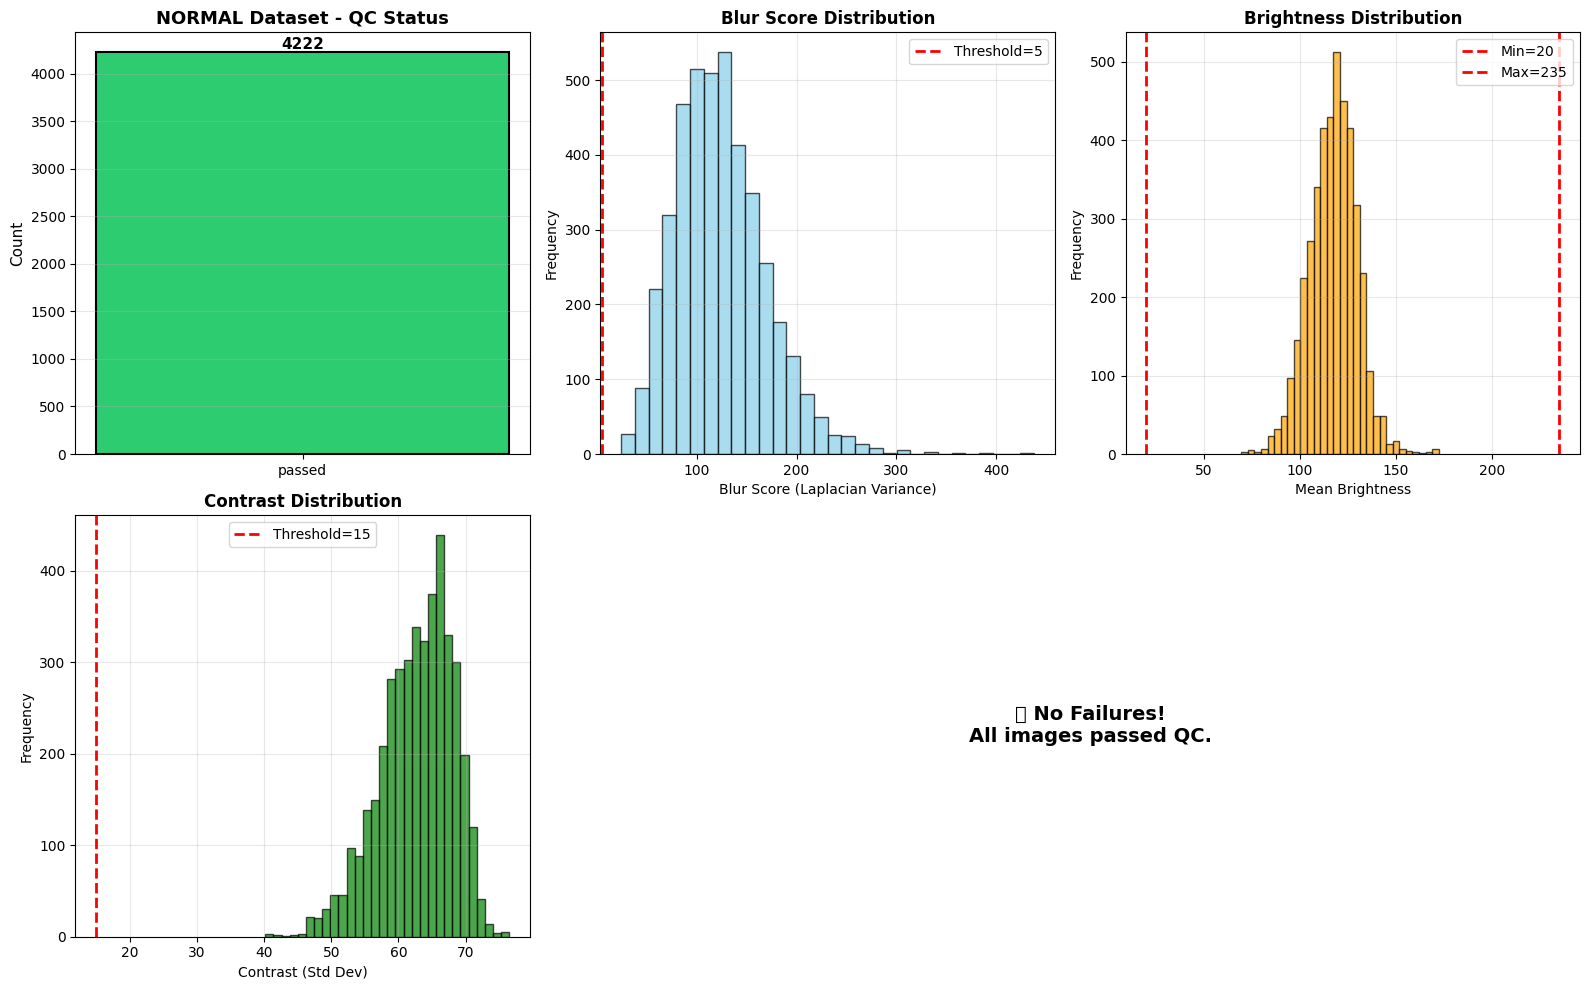

In [24]:
# Create comprehensive visualization (same structure as MMU)
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

# Plot 1: Status Distribution
ax1 = fig.add_subplot(gs[0, 0])
status_counts = normal_df['status'].value_counts()
colors = ['#2ecc71' if s == 'passed' else '#e74c3c' for s in status_counts.index]
bars = ax1.bar(status_counts.index, status_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('NORMAL Dataset - QC Status', fontsize=13, fontweight='bold')
for i, v in enumerate(status_counts.values):
    ax1.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Blur Scores
ax2 = fig.add_subplot(gs[0, 1])
if 'metrics' in normal_df.columns and len(normal_df) > 0:
    blur_scores = [m.get('blur_score', 0) if isinstance(m, dict) else 0 for m in normal_df['metrics']]
    ax2.hist(blur_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(QC_PARAMS['blur_threshold'], color='red', linestyle='--', linewidth=2, 
                label=f"Threshold={QC_PARAMS['blur_threshold']}")
    ax2.set_xlabel('Blur Score (Laplacian Variance)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Blur Score Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

# Plot 3: Brightness Distribution
ax3 = fig.add_subplot(gs[0, 2])
if 'metrics' in normal_df.columns and len(normal_df) > 0:
    brightness = [m.get('brightness', 0) if isinstance(m, dict) else 0 for m in normal_df['metrics']]
    ax3.hist(brightness, bins=30, color='orange', edgecolor='black', alpha=0.7)
    ax3.axvline(QC_PARAMS['brightness_min'], color='red', linestyle='--', linewidth=2, 
                label=f"Min={QC_PARAMS['brightness_min']}")
    ax3.axvline(QC_PARAMS['brightness_max'], color='red', linestyle='--', linewidth=2,
                label=f"Max={QC_PARAMS['brightness_max']}")
    ax3.set_xlabel('Mean Brightness', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('Brightness Distribution', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

# Plot 4: Contrast Distribution
ax4 = fig.add_subplot(gs[1, 0])
if 'metrics' in normal_df.columns and len(normal_df) > 0:
    contrast = [m.get('contrast', 0) if isinstance(m, dict) else 0 for m in normal_df['metrics']]
    ax4.hist(contrast, bins=30, color='green', edgecolor='black', alpha=0.7)
    ax4.axvline(QC_PARAMS['contrast_threshold'], color='red', linestyle='--', linewidth=2,
                label=f"Threshold={QC_PARAMS['contrast_threshold']}")
    ax4.set_xlabel('Contrast (Std Dev)', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.set_title('Contrast Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

# Plot 5: Failure Reasons
ax5 = fig.add_subplot(gs[1, 1:])
failed_df = normal_df[normal_df['status'] == 'failed']
if len(failed_df) > 0:
    # Count failure reasons
    all_reasons = []
    for reasons in failed_df['reasons']:
        if isinstance(reasons, list):
            all_reasons.extend(reasons)
    
    if all_reasons:
        reason_counts = pd.Series(all_reasons).value_counts()
        ax5.barh(range(len(reason_counts)), reason_counts.values, color='#e74c3c', edgecolor='black', alpha=0.7)
        ax5.set_yticks(range(len(reason_counts)))
        ax5.set_yticklabels([r[:50] + '...' if len(r) > 50 else r for r in reason_counts.index], fontsize=9)
        ax5.set_xlabel('Count', fontsize=10)
        ax5.set_title('Failure Reasons Distribution', fontsize=12, fontweight='bold')
        ax5.grid(axis='x', alpha=0.3)
        for i, v in enumerate(reason_counts.values):
            ax5.text(v + 0.5, i, str(v), va='center', fontsize=9)
else:
    ax5.text(0.5, 0.5, '✅ No Failures!\nAll images passed QC.', 
             ha='center', va='center', fontsize=14, fontweight='bold',
             transform=ax5.transAxes)
    ax5.axis('off')

plt.tight_layout()

# Save figure
normal_viz_path = QC_VISUALIZATIONS_DIR / "qc_summary_normal.png"
plt.savefig(normal_viz_path, dpi=150, bbox_inches='tight')
print(f"✅ Visualization saved: {normal_viz_path}")

plt.show()

## 3.4 Overall QC Summary

Combined summary of all three datasets after quality control processing.

OVERALL QC SUMMARY - ALL DATASETS

 Dataset  Total  Passed  Failed  Pass Rate %
STRESSED    102     102       0        100.0
     MMU    450     450       0        100.0
  NORMAL   4222    4222       0        100.0
   TOTAL   4774    4774       0        100.0

📄 Combined Summary CSV: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Reports\qc_summary_all_datasets.csv
✅ Overall visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_overall.png
✅ Overall visualization saved: G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results\QC_Visualizations\qc_summary_overall.png


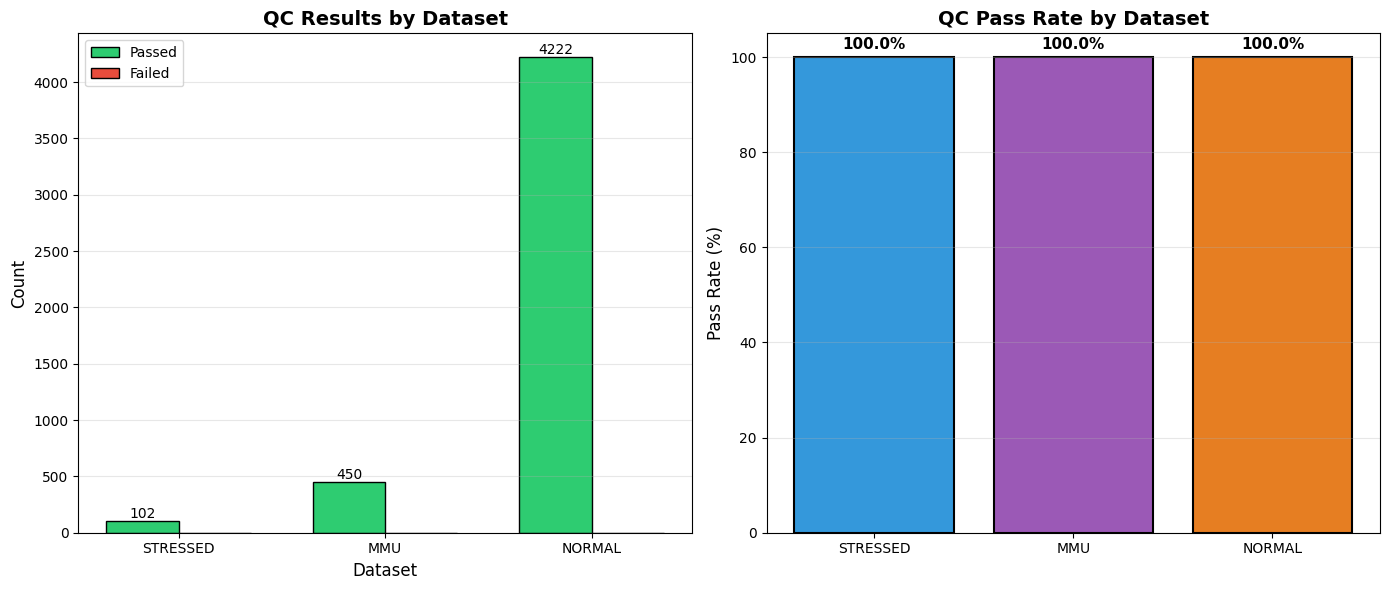


✅ QC PROCESSING COMPLETE FOR ALL DATASETS!

📁 Output Structure:
   G:\Iris_Stress_Detector\DataSet\Iris stream dataset\QC_Results/
   ├── QC_Passed/ (4774 images)
   │   ├── stressed/ (102 images)
   │   ├── mmu/ (450 images)
   │   └── normal/ (4222 images)
   ├── QC_Failed/ (0 images)
   ├── QC_Reports/ (CSV files)
   └── QC_Visualizations/ (PNG plots)

🎯 Ready for next stage: Detection & Analysis!


In [25]:
print("="*80)
print("OVERALL QC SUMMARY - ALL DATASETS")
print("="*80)

# Combine statistics from all datasets
summary_data = {
    'Dataset': ['STRESSED', 'MMU', 'NORMAL', 'TOTAL'],
    'Total': [
        len(stressed_df),
        len(mmu_df),
        len(normal_df),
        len(stressed_df) + len(mmu_df) + len(normal_df)
    ],
    'Passed': [
        (stressed_df['status'].isin(['passed', 'auto_pass'])).sum(),
        (mmu_df['status'] == 'passed').sum(),
        (normal_df['status'] == 'passed').sum(),
        (stressed_df['status'].isin(['passed', 'auto_pass'])).sum() + 
        (mmu_df['status'] == 'passed').sum() + 
        (normal_df['status'] == 'passed').sum()
    ],
    'Failed': [
        (stressed_df['status'] == 'failed').sum(),
        (mmu_df['status'] == 'failed').sum(),
        (normal_df['status'] == 'failed').sum(),
        (stressed_df['status'] == 'failed').sum() + 
        (mmu_df['status'] == 'failed').sum() + 
        (normal_df['status'] == 'failed').sum()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Pass Rate %'] = (summary_df['Passed'] / summary_df['Total'] * 100).round(1)

print("\n" + summary_df.to_string(index=False))

# Save combined summary
summary_csv_path = QC_REPORTS_DIR / "qc_summary_all_datasets.csv"
summary_df.to_csv(summary_csv_path, index=False)

print(f"\n📄 Combined Summary CSV: {summary_csv_path}")

# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Pass/Fail by Dataset
ax1 = axes[0]
datasets = summary_df['Dataset'][:-1]  # Exclude TOTAL row
x = np.arange(len(datasets))
width = 0.35

passed = summary_df['Passed'][:-1]
failed = summary_df['Failed'][:-1]

bars1 = ax1.bar(x - width/2, passed, width, label='Passed', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x + width/2, failed, width, label='Failed', color='#e74c3c', edgecolor='black')

ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('QC Results by Dataset', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Plot 2: Pass Rate Comparison
ax2 = axes[1]
pass_rates = summary_df['Pass Rate %'][:-1]
colors_pass = ['#3498db', '#9b59b6', '#e67e22']
bars = ax2.bar(datasets, pass_rates, color=colors_pass, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Pass Rate (%)', fontsize=12)
ax2.set_title('QC Pass Rate by Dataset', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, rate in zip(bars, pass_rates):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()

# Save figure
overall_viz_path = QC_VISUALIZATIONS_DIR / "qc_summary_overall.png"
plt.savefig(overall_viz_path, dpi=150, bbox_inches='tight')
print(f"✅ Overall visualization saved: {overall_viz_path}")

plt.show()

print("\n" + "="*80)
print("✅ QC PROCESSING COMPLETE FOR ALL DATASETS!")
print("="*80)
print(f"\n📁 Output Structure:")
print(f"   {OUTPUT_DIR}/")
print(f"   ├── QC_Passed/ ({summary_df['Passed'].iloc[-1]} images)")
print(f"   │   ├── stressed/ ({summary_df['Passed'].iloc[0]} images)")
print(f"   │   ├── mmu/ ({summary_df['Passed'].iloc[1]} images)")
print(f"   │   └── normal/ ({summary_df['Passed'].iloc[2]} images)")
print(f"   ├── QC_Failed/ ({summary_df['Failed'].iloc[-1]} images)")
print(f"   ├── QC_Reports/ (CSV files)")
print(f"   └── QC_Visualizations/ (PNG plots)")
print(f"\n🎯 Ready for next stage: Detection & Analysis!")